# Fast-food Analysis

As we have studied if the nutritional informations of the average product per area was correlated to the wellbeing features, we now want to study the correlation between this nutrients composition and the number of fast foods per area.

We were able to find the database from the Londonian data website, the same one as for the wellbeing features. 

In [1]:
# Imports
from utils import calculate_nutripoints
from sklearn.cluster import KMeans, DBSCAN
from statsmodels.stats import diagnostic
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy import stats
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_predict, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, auc, roc_curve, r2_score
from sklearn.feature_selection import RFE
import math
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline
sns.set_theme()

## I) Data Preparation 

### A) Data imports

In [2]:
# Data Imports

#year_grocery = pd.read_csv("data/year_osward_grocery.csv")
#display(year_grocery.head())

fast_food = pd.read_excel(
    "data/Fast_food.xlsx", sheet_name="Ward Data", header=[3], usecols="E,G")
display(fast_food.head())
print(fast_food.shape)


wellbeing_grocery = pd.read_pickle("data/wellbeing_grocery.pkl")
display(wellbeing_grocery.head())
print(wellbeing_grocery.shape)

# Selecting the nutrition columns from wellbeing_grocery
grocery_analysis = wellbeing_grocery.copy()
list_column = ["area_id", "energy_tot", "energy_fat", "energy_saturate", "energy_sugar", "energy_protein", "energy_carb",
               "energy_fibre", "energy_alcohol", "h_nutrients_calories", "nutripoints","nutri_label"]
grocery_analysis = grocery_analysis.loc[:,grocery_analysis.columns.isin(list(list_column))]

display(grocery_analysis.head())
print(grocery_analysis.shape)

,2015 Ward code,Count of outlets
0,E05001767,10
1,E05001768,10
2,E05001769,22
3,E05001770,81
4,E05001771,5


(5832, 2)


,area_id,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,...,Crime rate - Index,Deliberate Fires,Average Capped GCSE and Equivalent Point Score Per Pupil,Unauthorised Absence in All Schools (%),Dependent children in out-of-work families,Public Transport Accessibility,"Homes with access to open space & nature, and % greenspace",Subjective well-being average score,Index Score 2013,nutri_label
0,E05000336,78.864004,32.414378,38.719523,21.433875,71.160848,2.994211,1.741239,176.194176,1.582813,...,5.663200,1.732487,9.104353,14.362369,6.829642,-12.410936,5.496664,0.097080,4.798106,4
1,E05000605,84.561946,33.918637,36.141050,22.015479,69.832483,3.067818,1.697021,181.174746,1.575484,...,-17.140935,6.149262,5.553690,2.833274,2.724538,12.165452,-4.355219,4.064134,0.440499,0
2,E05000252,80.542785,31.635739,33.648475,22.141379,61.322242,3.149138,1.689631,168.845175,1.598050,...,5.477066,9.517488,18.843265,0.391431,4.402315,16.172939,-14.255212,9.646084,4.269507,1
3,E05000427,77.568453,30.521094,35.742617,22.364672,66.992603,2.985766,1.760651,171.672145,1.600125,...,-13.774964,8.269988,4.929764,7.254350,-10.552446,18.059347,-13.621024,1.783860,-2.659193,0
4,E05000595,82.975277,33.302798,37.707033,21.336347,71.447922,2.947414,1.372449,180.079409,1.559561,...,-6.697261,2.509921,-5.728663,-1.420357,3.504061,4.092038,9.694047,4.064134,-0.489500,0


(414, 26)


,area_id,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,nutripoints,nutri_label
0,E05000336,78.864004,32.414378,38.719523,21.433875,71.160848,2.994211,1.741239,176.194176,1.582813,10.0,4
1,E05000605,84.561946,33.918637,36.141050,22.015479,69.832483,3.067818,1.697021,181.174746,1.575484,9.0,0
2,E05000252,80.542785,31.635739,33.648475,22.141379,61.322242,3.149138,1.689631,168.845175,1.598050,8.5,1
3,E05000427,77.568453,30.521094,35.742617,22.364672,66.992603,2.985766,1.760651,171.672145,1.600125,9.0,0
4,E05000595,82.975277,33.302798,37.707033,21.336347,71.447922,2.947414,1.372449,180.079409,1.559561,9.0,0


(414, 12)


### B) Merging

We compare the number of lines of grocery and fast food and try to see how many they have in common. We then merge the two datasets.

In [31]:
boolean = not grocery_analysis["area_id"].is_unique      # True (credit to @Carsten)
print(boolean)

True


In [25]:
len(set(grocery_analysis["area_id"].values))

387

In [26]:
len(set(fast_food["2015 Ward code"].values))

5832

In [27]:
len(set(fast_food["2015 Ward code"].values)
    & set(grocery_analysis["area_id"].values))

382

REVOIR: As fast food dataset lists all the fast-foods of England and that the final merging dataset has only 4 missing rows compared to grocery_analysis, we can say that the merging does not loose information.  

In [28]:
fastfood_grocery = pd.merge(
    left=grocery_analysis, right=fast_food, left_on='area_id', right_on="2015 Ward code")
fastfood_grocery = fastfood_grocery.drop("2015 Ward code", axis=1)
display(fastfood_grocery.head())
print(fastfood_grocery.shape)

,area_id,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,nutripoints,nutri_label,Count of outlets
0,E05000336,78.864004,32.414378,38.719523,21.433875,71.160848,2.994211,1.741239,176.194176,1.582813,10.0,4,15
1,E05000605,84.561946,33.918637,36.141050,22.015479,69.832483,3.067818,1.697021,181.174746,1.575484,9.0,0,13
2,E05000252,80.542785,31.635739,33.648475,22.141379,61.322242,3.149138,1.689631,168.845175,1.598050,8.5,1,8
3,E05000427,77.568453,30.521094,35.742617,22.364672,66.992603,2.985766,1.760651,171.672145,1.600125,9.0,0,14
4,E05000595,82.975277,33.302798,37.707033,21.336347,71.447922,2.947414,1.372449,180.079409,1.559561,9.0,0,25


(407, 13)


## II) Comprehension of the data

### A) Distribution of the values: describe, boxplot, distplot

In [32]:
#checking that they are no null value
fastfood_grocery.isnull().any()

area_id                 False
energy_fat              False
energy_saturate         False
energy_sugar            False
energy_protein          False
energy_carb             False
energy_fibre            False
energy_alcohol          False
energy_tot              False
h_nutrients_calories    False
nutripoints             False
nutri_label             False
Count of outlets        False
dtype: bool

In [33]:
#Understanding better how the values are distributed
fastfood_grocery.describe()

,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,nutripoints,nutri_label,Count of outlets
count,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000
mean,80.784989,31.907750,40.296211,21.054377,72.155774,3.027468,1.678519,178.701127,1.571869,9.305897,1.744472,14.140049
std,2.831696,1.382985,3.250686,0.915000,5.274497,0.120171,0.350697,6.902516,0.024322,1.378196,1.578352,13.006347
min,67.111854,26.283257,33.119113,17.596480,58.462154,2.750710,0.715793,156.104396,1.465237,5.000000,0.000000,1.000000
25%,79.113366,31.032413,38.116707,20.592028,68.425923,2.947048,1.432738,174.190966,1.556295,8.500000,0.000000,7.000000
50%,80.523818,31.763461,39.809799,21.231804,72.175064,3.019550,1.669184,178.744798,1.573776,9.000000,1.000000,12.000000
75%,82.306504,32.659223,42.249893,21.682030,75.885690,3.095622,1.877371,182.698736,1.589703,10.500000,3.000000,17.000000
max,92.440804,38.690892,48.719140,23.005837,84.618879,3.617668,3.147601,197.674474,1.641436,14.500000,4.000000,147.000000


Text(0.5, 0.98, 'boxplot for each column')

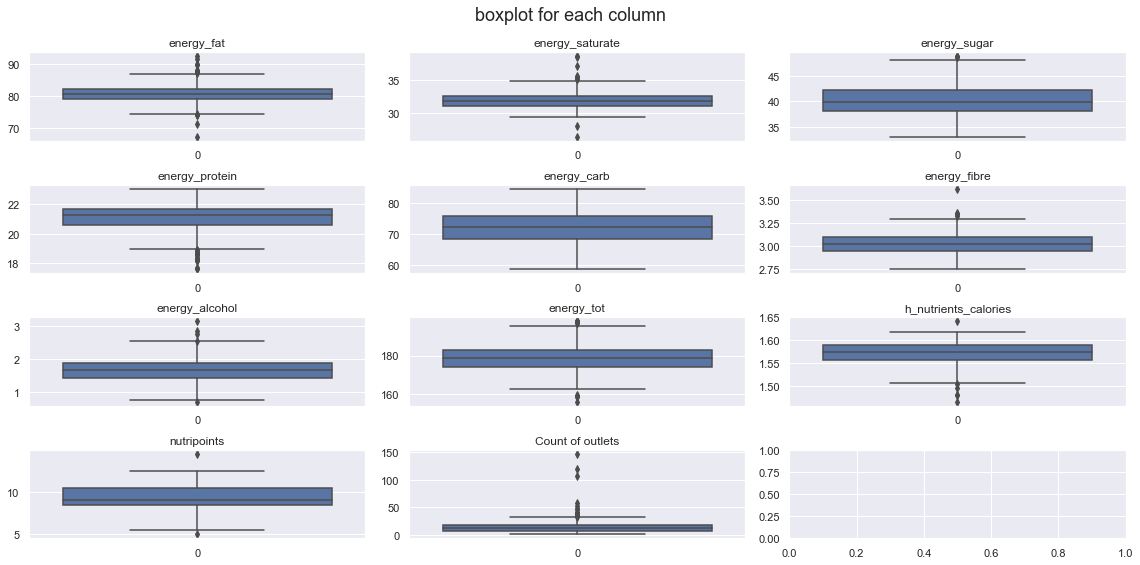

In [10]:
columns_grocery = [
    'energy_fat',
    'energy_saturate',
    'energy_sugar',
    'energy_protein',
    'energy_carb',
    'energy_fibre',
    'energy_alcohol',
    'energy_tot',
    'h_nutrients_calories',
    'nutripoints',
    'Count of outlets'
]

column_boxplot = columns_grocery

fastfood_grocery_analysis = fastfood_grocery[column_boxplot].copy()
fig, ax = plt.subplots(4, 3, figsize=(16, 8), sharey=False)

for i in range(len(column_boxplot)):
    sbplt = ax[int(i/3), i % 3]

    sns.boxplot(data=fastfood_grocery_analysis.iloc[:, i], ax=sbplt)
    sbplt.set_xlabel('')
    sbplt.set_ylabel('')
    sbplt.set_title(
        fastfood_grocery_analysis.columns[i], loc='center', wrap=True)

fig.tight_layout()
fig.subplots_adjust(top=0.9)

fig.suptitle('boxplot for each column', fontsize=18)

We observe that they are some outliers principally for the fast food. We will try to visualize it better later

Text(0.5, 0.98, 'histplot for each column')

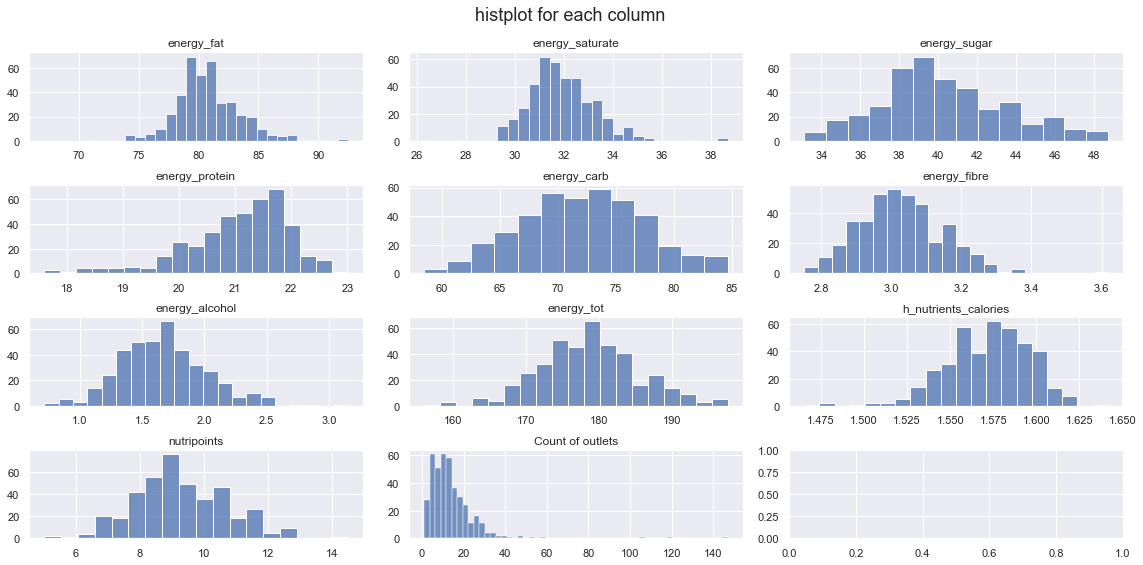

In [11]:
fig, ax = plt.subplots(4, 3, figsize=(16, 8), sharey=False)

for i in range(len(column_boxplot)):
    sbplt = ax[int(i/3), i % 3]

    sns.histplot(data=fastfood_grocery_analysis.iloc[:, i], ax=sbplt)
    sbplt.set_xlabel('')
    sbplt.set_ylabel('')
    sbplt.set_title(fastfood_grocery_analysis.columns[i], wrap=True)

fig.tight_layout()
fig.subplots_adjust(top=0.9)

fig.suptitle('histplot for each column', fontsize=18)

Most of the nutritional variables seem to be normally distributed. On the other side, the number of outlets is more logarithmic. Most of the areas have between 5 and 10 fast foods but it go to 140! 

### B) Correlation between the different variables

<AxesSubplot:>

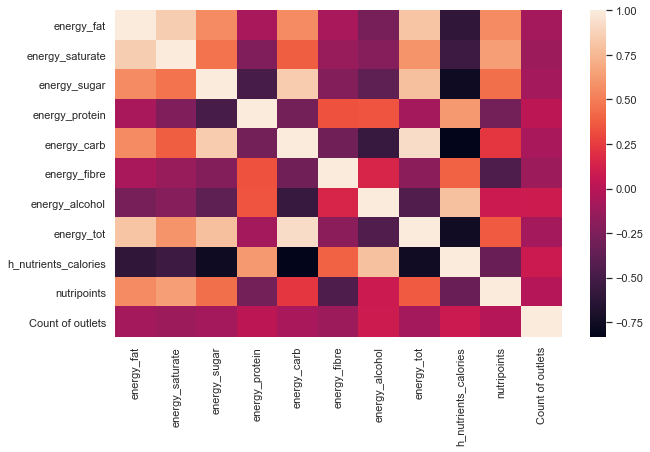

In [34]:
# Heatmap to visualize the correlation between the variables
fig = plt.figure(figsize=(10, 6))
sns.heatmap(fastfood_grocery_analysis.corr())

The correlation with the number of oulets (the last column or row) seems really lo as the colours are mainly red, corresponding to values around O. We will display the correlation table to better understand the importance of the correlation between the different variables. 

In [13]:
correlation = fastfood_grocery_analysis.corr(method="spearman")
display(correlation)

,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,nutripoints,Count of outlets
energy_fat,1.000000,0.801918,0.518136,-0.053873,0.525838,-0.019363,-0.305409,0.760481,-0.554461,0.491096,-0.093613
energy_saturate,0.801918,1.000000,0.430642,-0.176601,0.338711,-0.066967,-0.178426,0.520243,-0.428021,0.597296,-0.174806
energy_sugar,0.518136,0.430642,1.000000,-0.517018,0.840569,-0.299752,-0.390441,0.777607,-0.774996,0.447583,-0.077223
energy_protein,-0.053873,-0.176601,-0.517018,1.000000,-0.314546,0.374979,0.296345,-0.142548,0.551341,-0.319052,0.061245
energy_carb,0.525838,0.338711,0.840569,-0.314546,1.000000,-0.355473,-0.578671,0.930762,-0.858045,0.239123,-0.031150
energy_fibre,-0.019363,-0.066967,-0.299752,0.374979,-0.355473,1.000000,0.159259,-0.239326,0.408692,-0.446251,-0.232656
energy_alcohol,-0.305409,-0.178426,-0.390441,0.296345,-0.578671,0.159259,1.000000,-0.498126,0.801828,0.085766,0.056469
energy_tot,0.760481,0.520243,0.777607,-0.142548,0.930762,-0.239326,-0.498126,1.000000,-0.784482,0.324636,-0.046469
h_nutrients_calories,-0.554461,-0.428021,-0.774996,0.551341,-0.858045,0.408692,0.801828,-0.784482,1.000000,-0.294870,0.042514
nutripoints,0.491096,0.597296,0.447583,-0.319052,0.239123,-0.446251,0.085766,0.324636,-0.294870,1.000000,-0.000093


energy_fat             -0.093613
energy_saturate        -0.174806
energy_sugar           -0.077223
energy_protein          0.061245
energy_carb            -0.031150
energy_fibre           -0.232656
energy_alcohol          0.056469
energy_tot             -0.046469
h_nutrients_calories    0.042514
nutripoints            -0.000093
Count of outlets        1.000000
Name: Count of outlets, dtype: float64

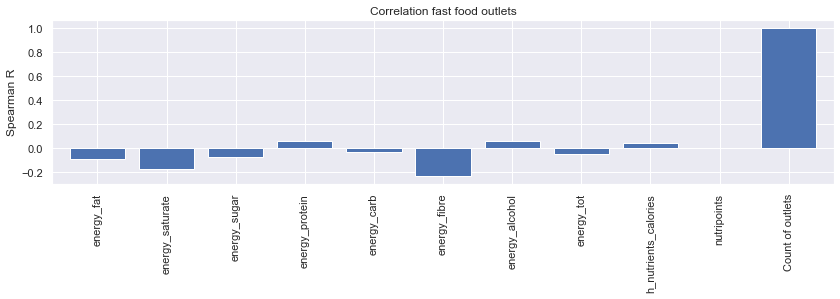

In [14]:
plt.figure(figsize=(14, 3))
display(correlation["Count of outlets"])
correlation["Count of outlets"].plot.bar(
    x=None, y=None, width=0.8, legend=None)
plt.ylabel("Spearman R")
plt.title("Correlation fast food outlets")
plt.show()

In [17]:
Y = fastfood_grocery[["nutripoints"]]
X = fastfood_grocery[["Count of outlets"]]
X = sm.add_constant(X)  # adding a constant

model = sm.OLS(Y, X).fit()
predictions = model.predict(X)

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:            nutripoints   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                   0.08910
Date:                Sat, 12 Dec 2020   Prob (F-statistic):              0.765
Time:                        16:56:32   Log-Likelihood:                -707.52
No. Observations:                 407   AIC:                             1419.
Df Residuals:                     405   BIC:                             1427.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                9.3281      0.101  

In [19]:
## linear regression ##
lin_reg = LinearRegression()  # create the model
lin_reg.fit(X, Y)  # train it

LinearRegression()

In [20]:
print("{0} * {1} + ".format(lin_reg.coef_[0], "Count of outlets"))
print(lin_reg.intercept_)

[ 0.         -0.00157156] * Count of outlets + 
[9.3281187]


In [21]:
# train a gradient boosting regressor
gradboost = GradientBoostingRegressor()

# compute r^2 for this new model
#r2_random_gradboost = gradboost_random.score(train_X, train_y)

#print(f"R² for the Gradient Boost Regression: {r2_random_gradboost}")

In [22]:
predicted_y = cross_val_predict(gradboost, X, Y, cv=5)

C:\Users\agath\anaconda3\envs\ada\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\agath\anaconda3\envs\ada\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\agath\anaconda3\envs\ada\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\agath\anaconda3\envs\ada\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 

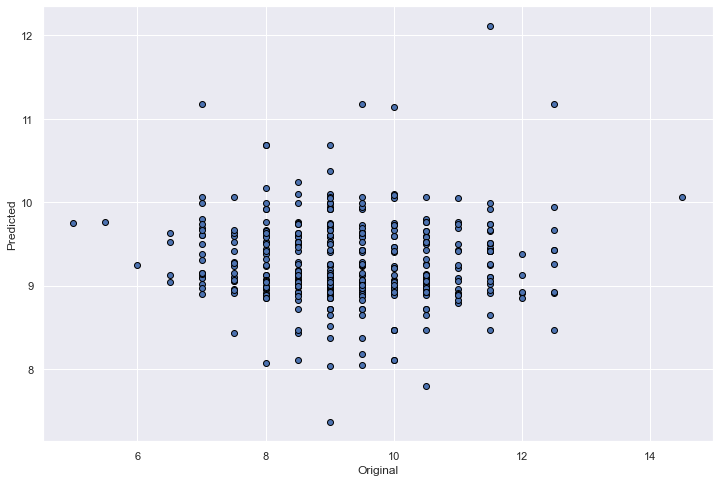

In [23]:
# Plot the results
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(Y, predicted_y, edgecolors=(0, 0, 0))
ax.set_xlabel('Original')
ax.set_ylabel('Predicted')
plt.show()

In [24]:
r2 = r2_score(Y, predicted_y)
mse = mean_squared_error(Y, predicted_y)
print(r2, mse)

-0.15425485824356278 2.1870317596555773
